<a href="https://colab.research.google.com/github/Philos250/birger/blob/master/jeandedh_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Passive Satellite data (Sentinel 2)**

In this assignment, your objective is to navigate the intricacies of utilizing Sentinel-2A satellite imagery
within a specific Region of Interest (ROI). In this task you will extract images for the districts
and time periods as shown in table 1 below, and subsequently perform crucial preprocessing steps.
These steps include; minimizing clouds, masking both clouds and their shadows, and ultimately
clipping the images to your assigned Region of Interest using Google Earth Engine (Python API).

1. To commence the assignment, start by preparing the shapefile/geojson of your assigned Region of Interest, and subsequently, delve into the acquisition of **Sentinel-2** MultiSpectral Instrument, Level-2A data **”COPERNICUS/S2 SR”** for the specified timeframe - check table 1 for your assigned region and time.

2. After acquiring the data, process your image collection and apply techniques to minimize clouds so that you have one image per month. For the resulting dataset, mask both clouds and their shadows. Elaborate on the techniques employed to minimize clouds in the satellite imagery and the process of masking both clouds and their shadows. Utilize the boundaries defined by the Rwanda sectors shapefile to clip the Sentinel-2A image collection to the selected Region of Interest.

3. Acknowledging that challenges may arise during data acquisition and processing, identify and discuss these challenges. Propose potential solutions or alternative approaches to address these obstacles effectively.

**NB:**
You will be required to find the data pertaining to this assignment by yourself. The data required
is;
- Shape files of the **ROI**
- Sentinel images for the time period you’re assigned.

Install usefully libraries

In [ ]:
# !pip  install PyCRS geedim

In [ ]:
# !pip install geedim

In [ ]:
# pip install earthengine-api

**Authenticate the user**

In [ ]:
from google.colab import auth
auth.authenticate_user('jeandedh')

**Initialize Earth Engine with the Authenticated Account**

In [ ]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='colline-401723')

**Load the Burera Shapefile into Earth Engine**

---



**Mount Google Drive in Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Access the Shapefile from Colab**

In [ ]:
!ls "/content/drive/My Drive/ML4EO/Burera/"

Burera_district.cpg  Burera_district.prj  Burera_district.sbx  Burera_district.shp.xml
Burera_district.dbf  Burera_district.sbn  Burera_district.shp  Burera_district.shx


**Load the Shapefile into Earth Engine**

In [ ]:
import ee  # Import the Earth Engine library

# Initialize the Earth Engine API
ee.Initialize()

# Load the shapefile for Burera district as a FeatureCollection from GEE assets
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

In [ ]:
roi

In [ ]:
Map = geemap.Map() # Initializing the Map Function

Map.centerObject(roi)

# Add the ROI to the map.
Map.addLayer(roi, {}, "ROI")

# Display the map.
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# **Sentinel-2 Cloud Masking with s2cloudle**

In [ ]:
AOI = roi
START_DATE = '2019-01-01'
END_DATE = '2019-12-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [ ]:
# Function to clip images to the specified ROI
def clip_to_roi(image):
    """Clips an image to the Burera district."""
    return image.clip(roi)

# **Build a Sentinel-2 collection**

In [ ]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))).map(clip_to_roi)

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)).map(clip_to_roi)

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    # Clip each image in the collection to the AOI.
    clipped_col = joined_col.map(clip_to_roi)

Apply the `get_s2_sr_cld_col` function to build a collection according to the parameters defined above.

In [ ]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

# **Define cloud mask component functions**

# **Cloud components**

Define a function to add the s2cloudless probability layer and derived cloud mask as bands to an S2 SR image input.

In [ ]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

**Cloud shadow components**

Define a function to add dark pixels, cloud projection, and identified shadows as bands to an S2 SR image input. Note that the image input needs to be the result of the above add_cloud_bands function because it relies on knowing which pixels are considered cloudy ('clouds' band).

In [ ]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

#### Final cloud-shadow mask

Define a function to assemble all of the cloud and cloud shadow components and produce the final mask.

In [ ]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

## Visualize and evaluate cloud mask components

This section provides functions for displaying the cloud and cloud shadow components. In most cases, adding all components to images and viewing them is unnecessary. This section is included to illustrate how the cloud/cloud shadow mask is developed and demonstrate how to test and evaluate various parameters, which is helpful when defining masking variables for an unfamiliar region or time of year.

In applications outside of this tutorial, if you prefer to include only the final cloud/cloud shadow mask along with the original image bands, replace:

```
return img_cloud_shadow.addBands(is_cld_shdw)
```

with

```
return img.addBands(is_cld_shdw)
```

in the above `add_cld_shdw_mask` function.

### Define functions to display image and mask component layers.

Folium will be used to display map layers. Import `folium` and define a method to display Earth Engine image tiles.

In [ ]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

Define a function to display all of the cloud and cloud shadow components to an interactive Folium map. The input is an image collection where each image is the result of the `add_cld_shdw_mask` function defined previously.

In [ ]:
# def display_cloud_layers(col):
#     # Mosaic the image collection.
#     img = col.mosaic()

#     # Subset layers and prepare them for display.
#     clouds = img.select('clouds').selfMask()
#     shadows = img.select('shadows').selfMask()
#     dark_pixels = img.select('dark_pixels').selfMask()
#     probability = img.select('probability')
#     cloudmask = img.select('cloudmask').selfMask()
#     cloud_transform = img.select('cloud_transform')

#     # Create a folium map object.
#     center = AOI.centroid(10).coordinates().reverse().getInfo()
#     m = folium.Map(location=center, zoom_start=12)

#     # Add layers to the folium map.
#     m.add_ee_layer(img,
#                    {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
#                    'S2 image', True, 1, 9)
#     m.add_ee_layer(probability,
#                    {'min': 0, 'max': 100},
#                    'probability (cloud)', False, 1, 9)
#     m.add_ee_layer(clouds,
#                    {'palette': 'e056fd'},
#                    'clouds', False, 1, 9)
#     m.add_ee_layer(cloud_transform,
#                    {'min': 0, 'max': 1, 'palette': ['white', 'black']},
#                    'cloud_transform', False, 1, 9)
#     m.add_ee_layer(dark_pixels,
#                    {'palette': 'orange'},
#                    'dark_pixels', False, 1, 9)
#     m.add_ee_layer(shadows, {'palette': 'yellow'},
#                    'shadows', False, 1, 9)
#     m.add_ee_layer(cloudmask, {'palette': 'orange'},
#                    'cloudmask', True, 0.5, 9)

#     # Add a layer control panel to the map.
#     m.add_child(folium.LayerControl())

#     # Display the map.
#     display(m)

In [ ]:
# Function to display cloud layers
def display_cloud_layers(col):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Get the centroid of the combined geometry
    centroid = AOI.geometry().centroid().coordinates().getInfo()
    lat, lon = centroid[1], centroid[0]  # Centroid returns [long, lat]

    # Create a folium map object.
    m = folium.Map(location=[lat, lon], zoom_start=12)

    # Add layers to the folium map.
    m.add_ee_layer(img,
                   {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                   'S2 image', True, 1, 9)
    m.add_ee_layer(probability,
                   {'min': 0, 'max': 100},
                   'probability (cloud)', False, 1, 9)
    m.add_ee_layer(clouds,
                   {'palette': 'e056fd'},
                   'clouds', False, 1, 9)
    m.add_ee_layer(cloud_transform,
                   {'min': 0, 'max': 1, 'palette': ['white', 'black']},
                   'cloud_transform', False, 1, 9)
    m.add_ee_layer(dark_pixels,
                   {'palette': 'orange'},
                   'dark_pixels', False, 1, 9)
    m.add_ee_layer(shadows, {'palette': 'yellow'},
                   'shadows', False, 1, 9)
    m.add_ee_layer(cloudmask, {'palette': 'orange'},
                   'cloudmask', True, 0.5, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

### Display mask component layers

Map the `add_cld_shdw_mask` function over the collection to add mask component bands to each image, then display the results.

Give the system some time to render everything, it should take less than a minute.

In [ ]:
s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

# Display the cloud layers
display_cloud_layers(s2_sr_cld_col_eval_disp)

### Evaluate mask component layers

In the above map, use the layer control panel in the upper right corner to toggle layers on and off; layer names are the same as band names, for easy code referral. Note that the layers have a minimum zoom level of 9 to avoid resource issues that can occur when visualizing layers that depend on the `ee.Image.reproject` function (used during cloud shadow project and mask dilation).

Try changing the above `CLD_PRB_THRESH`, `NIR_DRK_THRESH`, `CLD_PRJ_DIST`, and `BUFFER` input variables and rerunning the previous cell to see how the results change. Find a good set of values for a given overpass and then try the procedure with a new overpass with different cloud conditions (this [S2 SR image browser app](https://showcase.earthengine.app/view/s2-sr-browser-s2cloudless-nb) is handy for quickly identifying images and determining image collection filter criteria). Try to identify a set of parameter values that balances cloud/cloud shadow commission and omission error for a range of cloud types. In the next section, we'll use the values to actually apply the mask to generate a cloud-free composite for 2020.

## Apply cloud and cloud shadow mask

In this section we'll generate a cloud-free composite for the same region as above that represents mean reflectance for July and August, 2020.

### Define collection filter and cloud mask parameters

We'll redefine the parameters to be a little more aggressive, i.e. decrease the cloud probability threshold, increase the cloud projection distance, and increase the buffer. These changes will increase cloud commission error (mask out some clear pixels), but since we will be compositing images from three months, there should be plenty of observations to complete the mosaic.

In [ ]:
AOI = roi
START_DATE = '2019-01-01'
END_DATE = '2019-12-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 100

### Build a Sentinel-2 collection

Reassemble the S2-cloudless collection since the collection filter parameters have changed.

In [ ]:
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

### Define cloud mask application function

Define a function to apply the cloud mask to each image in the collection.

In [ ]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

### Process the collection

Add cloud and cloud shadow component bands to each image and then apply the mask to each image. Reduce the collection by median (in your application, you might consider using medoid reduction to build a composite from actual data values, instead of per-band statistics).

In [ ]:
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

### Display the cloud-free composite

Display the results. Be patient while the map renders, it may take a minute; [`ee.Image.reproject`](https://developers.google.com/earth-engine/guides/projections#reprojecting) is forcing computations to happen at 100 and 20 m scales (i.e. it is not relying on appropriate pyramid level [scales for analysis](https://developers.google.com/earth-engine/guides/scale#scale-of-analysis)). The issues with `ee.Image.reproject` being resource-intensive in this case are mostly confined to interactive map viewing. Batch image [exports](https://developers.google.com/earth-engine/guides/exporting) and table reduction exports where the `scale` parameter is set to typical Sentinel-2 scales (10-60 m) are less affected.



In [ ]:
# import folium
# import ee

# # Assuming ee and folium have been initialized and AOI is defined

# # Convert the ImageCollection to a single Image using the median reducer
# s2_sr_median_image = s2_sr_median.median()

# # Calculate the center of the AOI for the folium map
# center = AOI.geometry().centroid().coordinates().getInfo()
# center = [center[1], center[0]]  # Reverse the coordinates for folium (lat, lon)

# # Create a folium map object centered on the centroid
# m = folium.Map(location=center, zoom_start=12)

# # Define a helper function to add Earth Engine image layers to Folium map
# def add_ee_layer(self, ee_image_object, vis_params, name):
#     map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
#     folium.raster_layers.TileLayer(
#         tiles=map_id_dict['tile_fetcher'].url_format,
#         attr='Map Data © Google Earth Engine',
#         name=name,
#         overlay=True,
#         control=True
#     ).add_to(self)

# # Add Earth Engine drawing method to folium.Map
# folium.Map.add_ee_layer = add_ee_layer

# # Add the median composite layer to the folium map
# m.add_ee_layer(s2_sr_median_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'gamma': 1.1}, 'S2 cloud-free mosaic')

# # Add a layer control panel to the map
# m.add_child(folium.LayerControl())

# # Display the map
# m

# Create a folium map object.
center = AOI.geometry().centroid().coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12)

# Add layers to the folium map.
m.add_ee_layer(s2_sr_median,
                {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                'S2 cloud-free mosaic', True, 1, 9)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

Hopefully you now have a good sense for Sentinel-2 cloud masking in the cloud 😉 with Earth Engine.

### Process the collection

Add cloud and cloud shadow component bands to each image and then apply the mask to each image. Reduce the collection by median (in your application, you might consider using medoid reduction to build a composite from actual data values, instead of per-band statistics).

**Download Sentinel-2 Data**

In [ ]:
# import geemap
# import ee

# # Initialize the Earth Engine
# ee.Initialize()

# # Define your region of interest (roi) here
# # For example, roi could be an ee.Feature or ee.FeatureCollection
# # roi = ee.FeatureCollection('...') or roi = ee.Feature('...')

# # Adjust to your scene using sentinel
# start_date = '2019-01-01'
# end_date = '2019-12-31'

# # Cloud probability threshold
# CLOUD_FILTER = 60
# CLD_PRB_THRESH = 50

# # Function to mask clouds and shadows in Sentinel-2 imagery
# def mask_clouds_and_shadows(image):
#     # Get s2cloudless image and select the probability band
#     cld_prb = ee.Image(image.get('s2cloudless')).select('probability')
#     is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

#     # Use Sentinel-2's QA band to mask out cloud shadows
#     qa = image.select('QA60')

#     # Bits 10 and 11 are clouds and cirrus, respectively.
#     cloud_bitmask = 1 << 10
#     cirrus_bitmask = 1 << 11

#     # Both flags should be set to zero, indicating clear conditions.
#     mask = qa.bitwiseAnd(cloud_bitmask).eq(0) \
#             .And(qa.bitwiseAnd(cirrus_bitmask).eq(0))

#     # Return the masked image, scaled to reflectance, without the QA bands
#     return image.updateMask(is_cloud.Not()).updateMask(mask).select("B.*").divide(10000)

# # Sentinel-2 image collection
# s2_sr = (ee.ImageCollection("COPERNICUS/S2_SR")
#     .filterBounds(roi)
#     .filterDate(start_date, end_date)
#     .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

# # Import and filter s2cloudless
# s2_cld = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
#     .filterBounds(roi)
#     .filterDate(start_date, end_date))

# # Join the filtered s2cloudless collection to the SR collection by 'system:index' property
# image = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
#     'primary': s2_sr,
#     'secondary': s2_cld,
#     'condition': ee.Filter.equals(**{
#         'leftField': 'system:index',
#         'rightField': 'system:index'
#     })
# })).map(mask_clouds_and_shadows).median().clip(roi)

# # Create a Map instance
# mp = geemap.Map()

# # Automatically center the map at the region of interest
# mp.centerObject(roi, zoom=11)

# # Add the cloud-free median composite to the map
# mp.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'gamma': 1.1}, 'S2 cloud-free median')

# # Add layer control to switch between layers
# mp.add_layer_control()

# # Display the map
# mp


In [ ]:
# import geemap
# import ee

# # Initialize the Earth Engine
# ee.Initialize()

# # Define your region of interest (roi) here
# # roi = ee.FeatureCollection('...') or roi = ee.Feature('...')

# # Adjust to your scene using Sentinel-2
# start_date = '2019-01-01'
# end_date = '2019-12-31'

# # Cloud probability threshold
# CLOUD_FILTER = 60
# CLD_PRB_THRESH = 50

# # Function to add cloud and shadow bands
# def add_cloud_shadow_bands(img):
#     # Get s2cloudless image, subset the probability band.
#     cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

#     # Condition s2cloudless by the probability threshold value.
#     is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

#     # Use image metadata to estimate cloud shadow direction
#     solar_azimuth = img.getNumber('MEAN_SOLAR_AZIMUTH_ANGLE')
#     solar_zenith = ee.Number(90).subtract(img.getNumber('MEAN_SOLAR_ZENITH_ANGLE'))

#     # Assume cloud height to estimate shadow distance (this is a guess and will not be accurate)
#     cloud_height = ee.Number(2000)  # Convert cloud height to ee.Number
#     # Calculate shadow distance and round to the nearest integer to satisfy the API requirements
#     shadow_distance = cloud_height.divide(ee.Number.tan(solar_zenith.multiply(ee.Number(3.141592653589793)).divide(180))).round()

#     # Project shadows from clouds
#     is_shadow = is_cloud.directionalDistanceTransform(solar_azimuth, shadow_distance.divide(10).toInt())
#     # Reproject using the correct CRS string and setting scale separately
#     is_shadow = is_shadow.reproject(crs=img.select(0).projection().crs(), scale=10)
#     is_shadow = is_shadow.select('distance').lte(0).rename('shadows')

#     # Combine cloud and shadow masks
#     combined_mask = is_cloud.Or(is_shadow).Not()

#     # Mask clouds and shadows in the image
#     img_masked = img.updateMask(combined_mask)

#     # Add the cloud probability layer, cloud mask, and shadow mask as image bands
#     return img_masked.addBands(ee.Image([cld_prb, is_cloud, is_shadow]))

# # Sentinel-2 image collection
# s2_sr = (ee.ImageCollection("COPERNICUS/S2_SR")
#          .filterBounds(roi)
#          .filterDate(start_date, end_date)
#          .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

# # Import and filter s2cloudless
# s2_cld = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
#           .filterBounds(roi)
#           .filterDate(start_date, end_date))

# # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
# s2_sr_cld_joined = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(
#     primary=s2_sr,
#     secondary=s2_cld,
#     condition=ee.Filter.equals(
#         leftField='system:index',
#         rightField='system:index'
#     )
# ))

# # Map the function over the collection to add cloud and shadow bands
# s2_with_cloud_shadow = s2_sr_cld_joined.map(add_cloud_shadow_bands)

# # Take the median of the image collection
# image_median = s2_with_cloud_shadow.median().clip(roi)

# # Create a Map instance
# mp = geemap.Map()

# # Automatically center the map at the region of interest
# mp.centerObject(roi, zoom=11)

# # Add the cloud-free median composite to the map
# mp.addLayer(image_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'S2 cloud-free median')

# # Mask out clouds and shadows and add the result to the map
# mp.addLayer(image_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'gamma': 1.1}, 'clouds and shadows masked')

# # Add layer control to switch between layers
# mp.add_layer_control()

# # Display the map
# mp

# **2 Spectral Indices Mapping and Time-Series Analysis**

This question builds on question 1 aiming to explore the application of spectral indices, specifically **Enhanced Vegetation Index (EVI)**, **Normalized Difference Water Index (NDWI)**, and **Normalized Difference Built-up Index (NDBI)**. For this question you will use **Landsat8 Collection2 Tier1 Level2** data that is calibrated for radiometric and geometric consistency and atmospheric correction has been applied. Your task is to compute these spectral indices and generate maps for three different
time points corresponding to different seasons specifically, **January, July**, and **November**. Use the same **ROI** as in **question1** and the following code to download the data;

Start_date, end_date = ’2018-01-01’, ’2018-12-31’
landsat_collection = ee.ImageCollection(’LANDSAT/LC08/C02/T1_L2’)\
.filterDate(start_date, end_date) \
.filterBounds(roi) \
.map(maskCloudAndShadow) \
.map(lambda img: img.clip(roi))
def maskCloudAndShadow(image):
return NotImplemented

1. Explaining the significance of the selected spectral indices **(EVI, NDWI, and NDBI)** in understanding land dynamics and environmental changes. Elaborate on how each index provides valuable information regarding vegetation health, water presence, and urban development.

2. Generate and present the time series plots for each spectral index, focusing on the temporal trends and fluctuations observed over the designated period. Interpret the patterns, discussing any notable events or changes reflected in the time series data. Consider the practical implications of analyzing time series data for land monitoring, agriculture, and environmental assessments. Discuss potential applications of the information derived from the time series
analysis.

3. For the three chosen time points **(January, July, and November)**, generate maps illustrating the spatial distribution of EVI, NDWI, and NDBI. Discuss any noticeable patterns or changes in the indices over the different seasons, and provide interpretations of these observations.

# **2 Spectral Indices Mapping and Time-Series Analysis**

**Enhanced Vegetation Index (EVI)**

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine
ee.Initialize()

# Define the ROI
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2018-01-01'
end_date = '2018-12-31'
# Function to calculate EVI using the Landsat 8 bands
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }).rename('EVI')
    # The function must return an ee.Image
    return image.addBands(evi)

# Landsat 8 collection
landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi)
                      .map(calculate_evi))

# Function to extract mean EVI from an image
def mean_evi(image):
    mean = image.select('EVI').reduceRegion(reducer=ee.Reducer.mean(), geometry=roi.geometry(), scale=30).get('EVI')
    return ee.Feature(None, {'mean': mean, 'date': image.date().format()})

# Apply the EVI calculation to the Landsat collection
landsat_evi = landsat_collection.map(calculate_evi)

# Map the mean EVI function over the collection
evi_timeseries = landsat_evi.map(mean_evi)

# Fetch the results
evi_data = evi_timeseries.getInfo()

# Process the results into a format for plotting
dates = [pd.to_datetime(f['properties']['date']) for f in evi_data['features'] if f['properties']['mean'] is not None]
evi_values = [f['properties']['mean'] for f in evi_data['features'] if f['properties']['mean'] is not None]

# Plot the EVI time series
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(dates, evi_values, marker='.', linestyle='-', color='green', label='EVI')  # Add a label for the legend
plt.title('EVI Time Series for Burera District')
plt.xlabel('Date')
plt.ylabel('EVI')
plt.grid(True)
plt.legend()
plt.show()

**Normalized Difference Water Index (NDWI)**

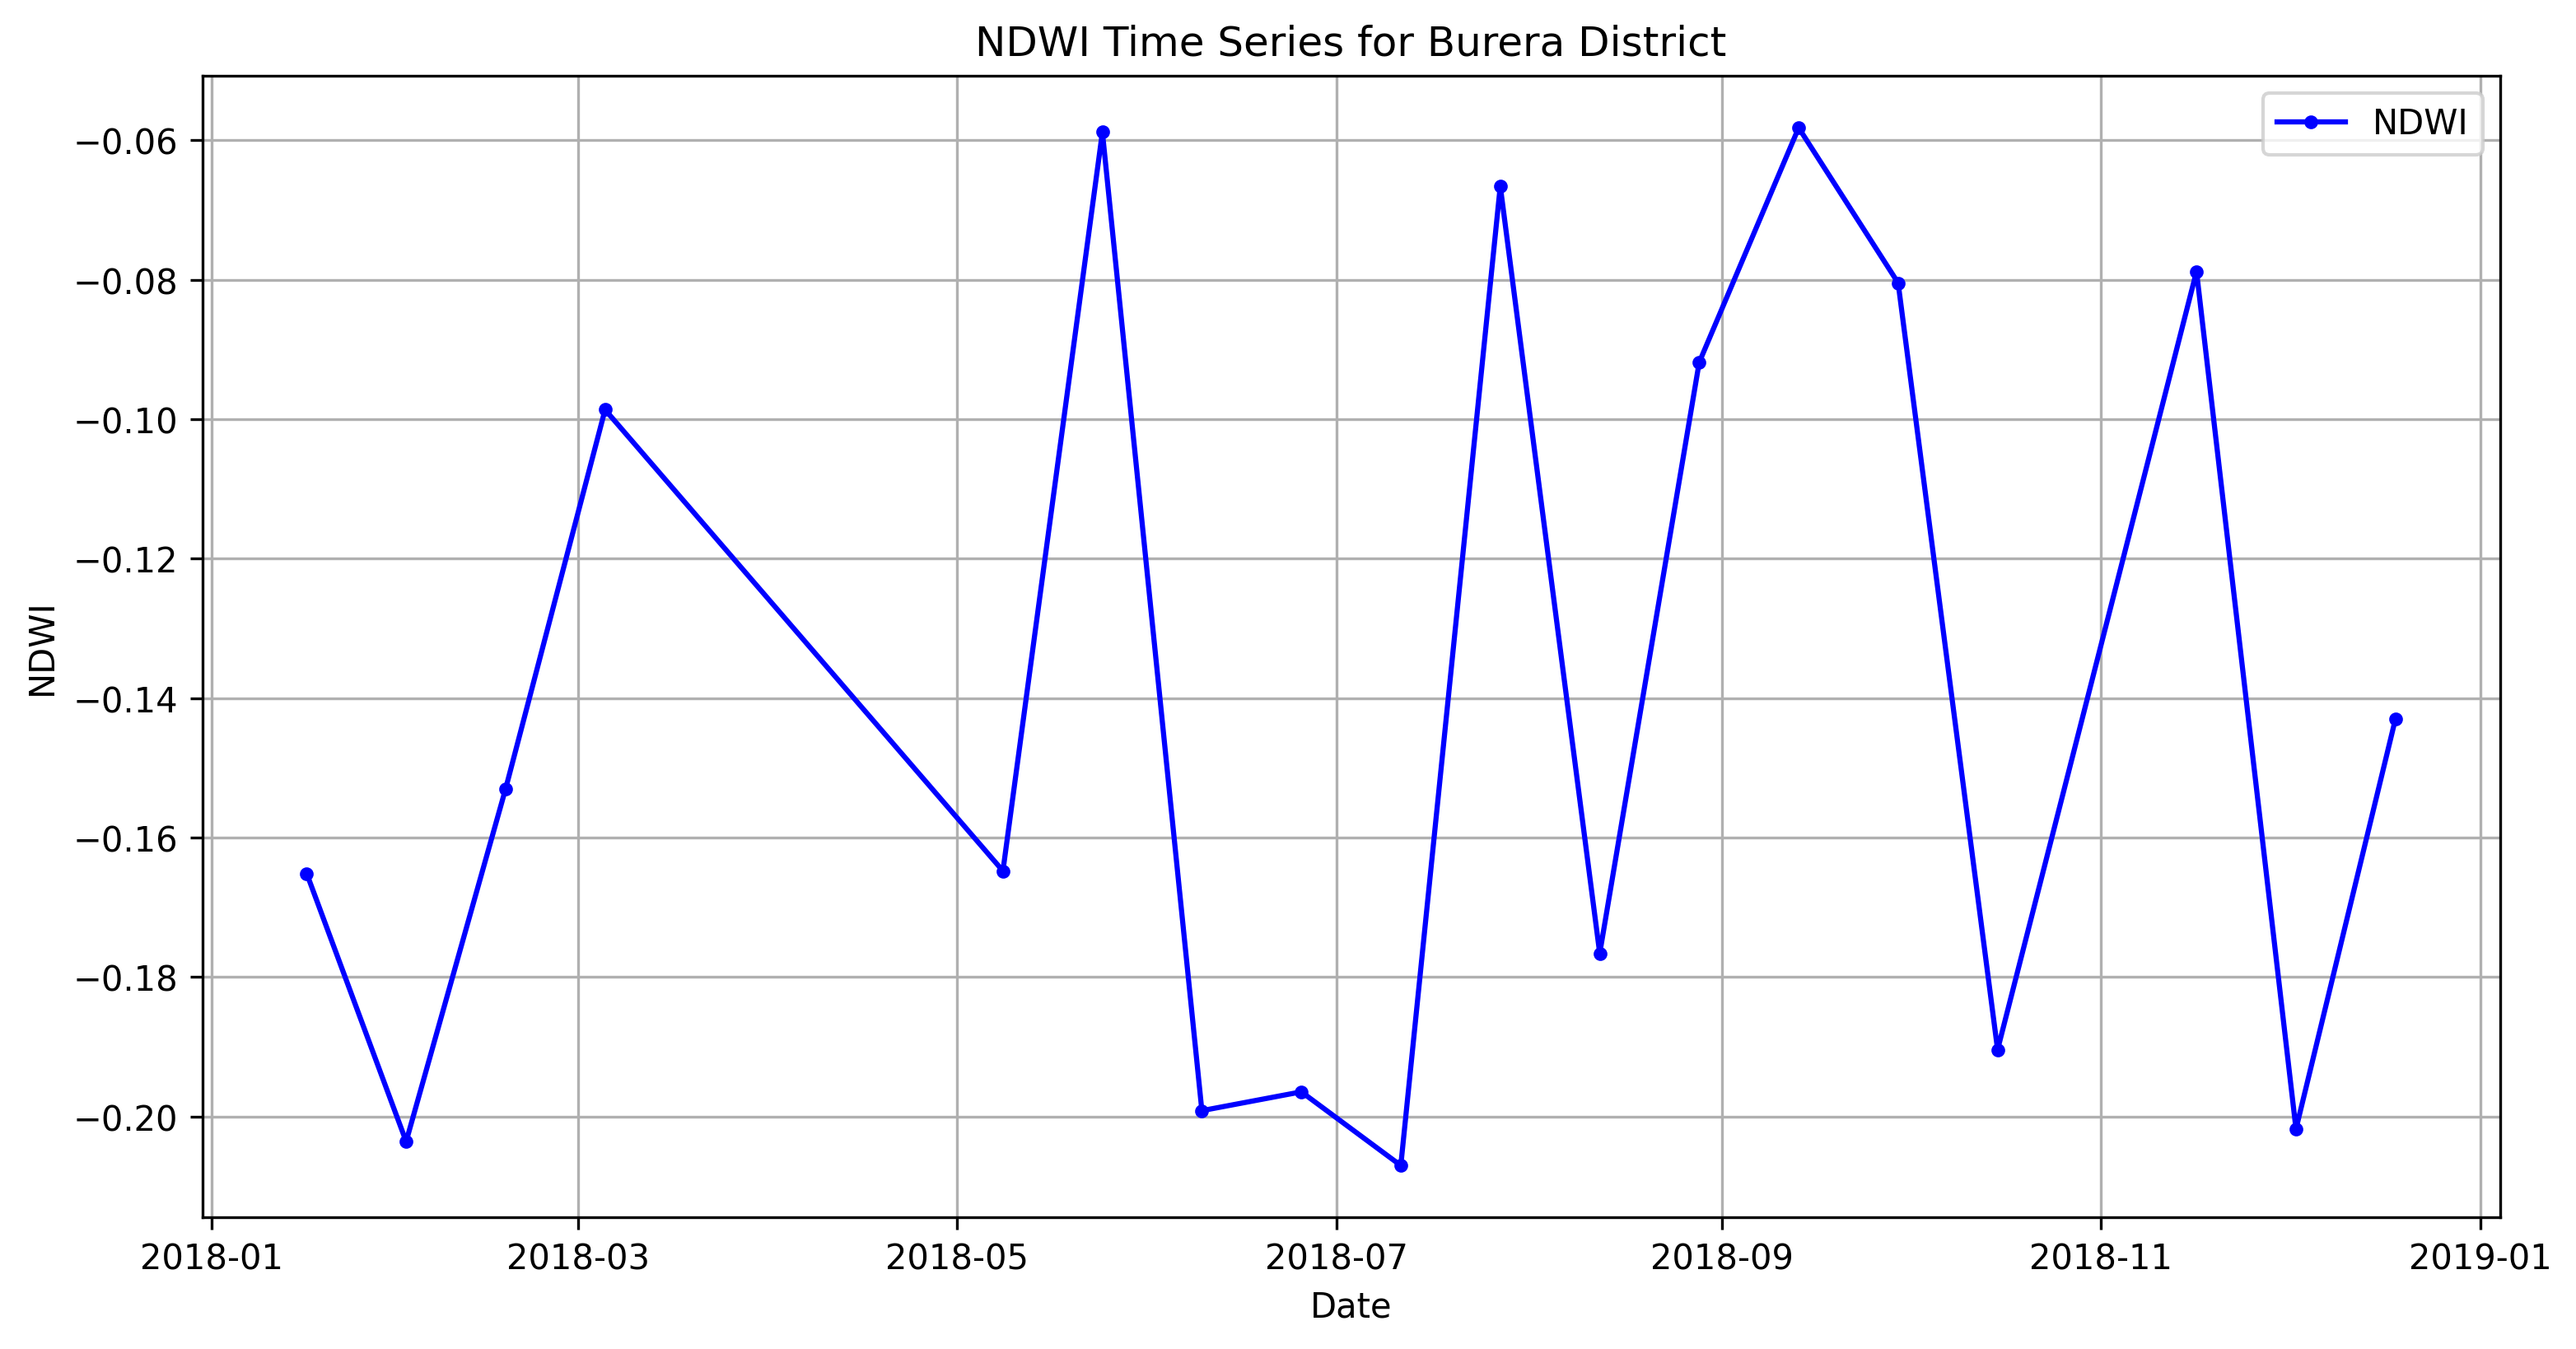

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2018-01-01'
end_date = '2018-12-31'

# Load the Landsat 8 Collection 2 Level-2 imagery
landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi))

# Function to calculate NDWI using the Landsat 8 bands
def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return image.addBands(ndwi)

# Apply the NDWI calculation to the Landsat collection
landsat_ndwi = landsat_collection.map(calculate_ndwi)

# Function to extract mean NDWI from an image
def mean_ndwi(image):
    mean = image.select('NDWI').reduceRegion(reducer=ee.Reducer.mean(), geometry=roi.geometry(), scale=30).get('NDWI')
    return ee.Feature(None, {'mean': mean, 'date': image.date().format()})

# Map the function over the collection
ndwi_timeseries = landsat_ndwi.map(mean_ndwi)

# Extract the list of date and mean NDWI values
ndwi_list = ndwi_timeseries.reduceColumns(ee.Reducer.toList(2), ['mean', 'date']).values().get(0)

# Retrieve the data from the server
ndwi_data = ndwi_list.getInfo()

# Separate the dates and NDWI values
dates = [pd.to_datetime(data[1]) for data in ndwi_data]
ndwi_values = [data[0] for data in ndwi_data]

# Plot the NDWI time series
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(dates, ndwi_values, marker='.', linestyle='-', color='blue', label='NDWI')
plt.title('NDWI Time Series for Burera District')
plt.xlabel('Date')
plt.ylabel('NDWI')
plt.grid(True)
plt.legend()
plt.show()

**Normalized Difference Built-up Index (NDBI)**

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2018-01-01'
end_date = '2018-12-31'

# Load the Landsat 8 Collection 2 Level-2 imagery
landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi))

# Function to calculate NDBI using the Landsat 8 bands
def calculate_ndbi(image):
    ndbi = image.normalizedDifference(['SR_B7', 'SR_B5']).rename('NDBI')
    return image.addBands(ndbi)

# Apply the NDBI calculation to the Landsat collection
landsat_ndbi = landsat_collection.map(calculate_ndbi)

# Function to extract mean NDBI from an image
def mean_ndbi(image):
    mean = image.select('NDBI').reduceRegion(reducer=ee.Reducer.mean(), geometry=roi.geometry(), scale=30).get('NDBI')
    return ee.Feature(None, {'mean': mean, 'date': image.date().format()})

# Map the function over the collection
ndbi_timeseries = landsat_ndbi.map(mean_ndbi)

# Extract the list of date and mean NDBI values
ndbi_list = ndbi_timeseries.reduceColumns(ee.Reducer.toList(2), ['mean', 'date']).values().get(0)

# Retrieve the data from the server
ndbi_data = ndbi_list.getInfo()

# Separate the dates and NDBI values
dates = [pd.to_datetime(data[1]) for data in ndbi_data]
ndbi_values = [data[0] for data in ndbi_data]

# Plot the NDBI time series
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(dates, ndbi_values, marker='.', linestyle='-', color='red', label='NDBI')
plt.title('NDBI Time Series for Burera District')
plt.xlabel('Date')
plt.ylabel('NDBI')
plt.grid(True)
plt.legend()
plt.show()

# **ON ONE GRAPH**

In [ ]:
import matplotlib.dates as mdates

# Convert dates from string to datetime objects for plotting
dates = pd.to_datetime(dates)

# Create a DataFrame from the data
data = {
    'Date': dates,
    'EVI': evi_values,
    'NDWI': ndwi_values,
    'NDBI': ndbi_values
}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(12, 6), dpi=300)

# Plot each index
plt.plot(df.index, df['EVI'], label='EVI', color='green', marker='.', linestyle='-')
plt.plot(df.index, df['NDWI'], label='NDWI', color='blue', marker='.', linestyle='-')
plt.plot(df.index, df['NDBI'], label='NDBI', color='red', marker='.', linestyle='-')

# Formatting the plot
plt.title('EVI, NDWI, and NDBI Time Series for Burera District (2019)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)

# Format the x-axis to show each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotate the dates for better readability

plt.show()

3. For the three chosen time points **(January, July, and November)**, generate maps illustrating the spatial distribution of EVI, NDWI, and NDBI. Discuss any noticeable patterns or changes in the indices over the different seasons, and provide interpretations of these observations.

In [ ]:
import ee
import geemap

# Initialize the Earth Engine
ee.Initialize()

# Define the ROI
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Visualization parameters for ROI
roi_style = {'color': 'yellow', 'fillColor': '00000000'}  # Yellow outline, no fill

# Function to calculate EVI, NDWI, and NDBI
def add_indices(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
          'NIR': image.select('SR_B5'),
          'RED': image.select('SR_B4'),
          'BLUE': image.select('SR_B2')
        }).rename('EVI')
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    return image.addBands([evi, ndwi, ndbi])

# Load Landsat 8 imagery and filter by date and ROI
def get_image(date):
    return (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterBounds(roi)
            .filterDate(ee.Date(date), ee.Date(date).advance(1, 'month'))
            .map(add_indices)
            .median()
            .clip(roi))

# Define visualization parameters
vis_params = {
    'EVI': {'min': 0, 'max': 1, 'palette': ['white', 'green']},
    'NDWI': {'min': -0.5, 'max': 0.5, 'palette': ['white', 'blue']},
    'NDBI': {'min': -0.1, 'max': 0.1, 'palette': ['white', 'red']}
}

# Create a map for the given date and index
def create_map(date, index, title):
    image = get_image(date)
    Map = geemap.Map()
    Map.centerObject(roi, 8)
    Map.addLayer(image.select(index), vis_params[index], index)
    Map.addLayer(roi.style(**roi_style), {}, 'ROI')  # Add the ROI as a layer with styling
    Map.addLayerControl()  # Add layer control to switch between layers
    Map.setControlVisibility(layerControl=True, fullscreenControl=False, latLngPopup=True)
    Map.setOptions(title=title)  # Set the title of the map
    return Map

# Generate maps for each index and for January, July, and November
months = ['2019-01-01', '2019-07-01', '2019-11-01']
indices = ['EVI', 'NDWI', 'NDBI']

for month in months:
    for index in indices:
        title = f"{index} for Burera District - {month}"
        map_obj = create_map(month, index, title)
        display(map_obj)
        print("\n" * 2)  # Add space between the maps


Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import ee
import geemap

# Initialize the Earth Engine
ee.Initialize()

# Define the ROI
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Visualization parameters for ROI
roi_style = {'color': 'yellow', 'fillColor': '00000000'}  # Yellow outline, no fill

# Function to calculate EVI, NDWI, and NDBI
def add_indices(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
          'NIR': image.select('SR_B5'),
          'RED': image.select('SR_B4'),
          'BLUE': image.select('SR_B2')
        }).rename('EVI')
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    return image.addBands([evi, ndwi, ndbi])

# Load Landsat 8 imagery and filter by date and ROI
def get_image(date):
    return (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterBounds(roi)
            .filterDate(ee.Date(date), ee.Date(date).advance(1, 'month'))
            .map(add_indices)
            .median()
            .clip(roi))

# Define visualization parameters
vis_params = {
    'EVI': {'min': 0, 'max': 1, 'palette': ['white', 'green']},
    'NDWI': {'min': -0.5, 'max': 0.5, 'palette': ['white', 'blue']},
    'NDBI': {'min': -0.1, 'max': 0.1, 'palette': ['white', 'red']}
}

# Create a map for the given date and index
def create_map(date, index):
    image = get_image(date)
    Map = geemap.Map()
    Map.centerObject(roi, 8)

    # Add the index layer with a name that includes the index and the month
    layer_name = f"{index} - {date}"
    Map.addLayer(image.select(index), vis_params[index], layer_name)

    # Add the ROI as a layer with styling and a name that includes the month
    roi_layer_name = f"ROI - {date}"
    Map.addLayer(roi.style(**roi_style), {}, roi_layer_name)

    # Add layer control to switch between layers
    Map.addLayerControl()

    return Map

# Generate maps for each index and for January, July, and November
months = ['2019-01-01', '2019-07-01', '2019-11-01']
indices = ['EVI', 'NDWI', 'NDBI']

# Store the generated Map objects
map_objects = []

for month in months:
    temp_maps = {}
    for index in indices:
        map_obj = create_map(month, index)
        map_objects.append(map_obj)  # Add the Map object to the list

# Display the maps with titles indicating the index and month
for map_obj in map_objects:
    display(map_obj)

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import os

# Function to download the image for the given date and index
def download_image(image, date, index, folder='downloaded_maps'):
    if not os.path.exists(folder):
        os.makedirs(folder)

    filename = f"{index}_{date.replace('-', '')}"  # e.g., 'EVI_20190101'
    path = os.path.join(folder, filename)

    # Assuming geemap and roi are defined and correctly set up elsewhere in your code
    geemap.ee_export_image_to_drive(image.select(index), description=filename, folder=folder, region=roi.geometry(), scale=30)
    print(f"Image {filename} has been sent to Google Drive.")

# Define the download_folder variable
download_folder = 'downloaded_maps'  # Or any specific folder name you want

# Assuming 'months' and 'indices' are defined and correctly set up elsewhere in your code
for month in months:
    image = get_image(month)  # Assuming get_image() is defined and correctly set up elsewhere in your code
    for index in indices:
        download_image(image, month, index, folder=download_folder)

Image EVI_20190101 has been sent to Google Drive.
Image NDWI_20190101 has been sent to Google Drive.
Image NDBI_20190101 has been sent to Google Drive.
Image EVI_20190701 has been sent to Google Drive.
Image NDWI_20190701 has been sent to Google Drive.
Image NDBI_20190701 has been sent to Google Drive.
Image EVI_20191101 has been sent to Google Drive.
Image NDWI_20191101 has been sent to Google Drive.
Image NDBI_20191101 has been sent to Google Drive.


In [ ]:
import os
import geemap
import ee  # Ensure Earth Engine Python API is imported

# Initialize the Earth Engine module.
ee.Initialize()

# Function to download the image for the given date and index
def download_image(image, date, index, folder='downloaded_maps', roi=None):
    # Make sure the download directory exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    filename = f"{index}_{date.replace('-', '')}.jpg"  # e.g., 'EVI_20190101.jpg'
    path = os.path.join(folder, filename)

    # Define visualization parameters
    visualization_parameters = {
        'min': 0,  # Minimum value for visualization
        'max': 3000,  # Maximum value for visualization, adjust as needed
        'bands': [index],  # Adjust based on your image bands
    }

    # Apply visualization parameters
    visualized_image = image.select(index).visualize(**visualization_parameters)

    # Export the visualized image as a JPG file
    geemap.ee_export_image(visualized_image, filename=path, scale=30, region=roi.geometry())
    print(f"Image {filename} has been downloaded to {folder}.")

# Assuming 'months', 'indices', 'download_folder', and 'roi' are defined earlier in your code
for month in months:
    image = get_image(month)  # Ensure this function returns an ee.Image object
    for index in indices:
        download_image(image, month, index, folder=download_folder, roi=roi)


The filename must end with .tif
Image EVI_20190101.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image NDWI_20190101.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image NDBI_20190101.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image EVI_20190701.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image NDWI_20190701.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image NDBI_20190701.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image EVI_20191101.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image NDWI_20191101.jpg has been downloaded to downloaded_maps.
The filename must end with .tif
Image NDBI_20191101.jpg has been downloaded to downloaded_maps.


# **2 Spectral Indices Mapping and Time-Series Analysis**
This question builds on question 1 aiming to explore the application of spectral indices, specifically **Enhanced Vegetation Index (EVI),** **Normalized Difference Water Index (NDWI)**, and **Normalized Difference Built-up Index (NDBI)**. For this question you will use **Landsat8 Collection2 Tier1 Level2 data** that is calibrated for radiometric and geometric consistency and atmospheric correction has been applied. Your task is to compute these spectral indices and generate maps for three different time points corresponding to different seasons specifically, **January, July, and November**. Use the
same **ROI** as in **question1** and the following code to download the data:

Start_date, end_date = ’2018-01-01’, ’2018-12-31’
landsat_collection = ee.ImageCollection(’LANDSAT/LC08/C02/T1_L2’)\
.filterDate(start_date, end_date) \
.filterBounds(roi) \
.map(maskCloudAndShadow) \
.map(lambda img: img.clip(roi))
def maskCloudAndShadow(image):
return NotImplemented

**1.** Explaining the significance of the selected spectral indices **(EVI, NDWI, and NDBI)** in understanding land dynamics and environmental changes. Elaborate on how each index provides valuable information regarding **vegetation health, water presence**, and **urban development**.

**2.** Generate and present the time series plots for each spectral index, focusing on the temporal trends and fluctuations observed over the designated period. Interpret the patterns, discussing any notable events or changes reflected in the time series data. Consider the practical implications of analyzing time series data for **land monitoring, agriculture,** and **environmental** **assessments.**

# **Enhanced Vegetation Index (EVI)**

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Initialize the Earth Engine
ee.Initialize()

# Define the ROI
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2018-01-01'
end_date = '2018-12-31'

# Function to mask clouds and shadows
def maskCloudAndShadow(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).clip(roi)

# Function to calculate EVI using the Landsat 8 bands
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }).rename('EVI')
    return image.addBands(evi)

# Apply cloud masking and calculate EVI
landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi)
                      .map(maskCloudAndShadow)  # Apply cloud masking and clipping
                      .map(calculate_evi))

# Function to extract mean EVI from an image
def mean_evi(image):
    mean = image.select('EVI').reduceRegion(reducer=ee.Reducer.mean(), geometry=roi.geometry(), scale=30, maxPixels=1e9).get('EVI')
    return ee.Feature(None, {'mean': mean, 'date': image.date().format()})

# Map the mean EVI function over the collection
evi_timeseries = landsat_collection.map(mean_evi)

# Fetch the results
evi_data = evi_timeseries.getInfo()

# Process the results into a format for plotting
# Process the results into a format for plotting
dates = [pd.to_datetime(f['properties']['date']) for f in evi_data['features'] if f['properties'].get('mean') is not None]
evi_values = [f['properties'].get('mean') for f in evi_data['features'] if f['properties'].get('mean') is not None]


# Plot the EVI time series
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(dates, evi_values, marker='.', linestyle='-', color='green', label='EVI')
plt.title('EVI Time Series for Burera District')
plt.xlabel('Date')
plt.ylabel('EVI')

# Format the x-axis to show each month and rotate date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Automatic rotation
plt.xticks(rotation=45)  # Explicitly set rotation

plt.grid(True)
plt.legend()
plt.show()

# **Insights**

# **Normalized Difference Water Index (NDWI)**

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2018-01-01'
end_date = '2018-12-31'

# Load the Landsat 8 Collection 2 Level-2 imagery
landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi))

# Mask clouds and shadows
def maskCloudAndShadow(image):
    qa = image.select('QA_PIXEL')
    # Cloud or shadow bit mask
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    # Mask pixels with cloud or shadow
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)

# Function to calculate NDWI using the Landsat 8 bands and clip to the ROI
def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    return image.addBands(ndwi).clip(roi)

# Apply cloud masking and the NDWI calculation to the Landsat collection
landsat_ndwi = landsat_collection.map(maskCloudAndShadow).map(calculate_ndwi)

# Function to extract mean NDWI from an image
def mean_ndwi(image):
    mean = image.select('NDWI').reduceRegion(reducer=ee.Reducer.mean(), geometry=roi.geometry(), scale=30, maxPixels=1e9).get('NDWI')
    return ee.Feature(None, {'mean': mean, 'date': image.date().format()})

# Map the function over the collection
ndwi_timeseries = landsat_ndwi.map(mean_ndwi)

# Extract the list of date and mean NDWI values
ndwi_list = ndwi_timeseries.reduceColumns(ee.Reducer.toList(2), ['mean', 'date']).values().get(0)

# Retrieve the data from the server
ndwi_data = ndwi_list.getInfo()

# Separate the dates and NDWI values
dates = [pd.to_datetime(data[1]) for data in ndwi_data]
ndwi_values = [data[0] for data in ndwi_data]

# Plot the NDWI time series
plt.figure(figsize=(12, 6),dpi=300)
plt.plot(dates, ndwi_values, marker='.', linestyle='-', color='blue', label='NDWI')  # Add a label for the legend
plt.title('NDWI Time Series for Burera District')
plt.xlabel('Date')
plt.ylabel('NDWI')
plt.xticks(rotation=45)  # Rotate dates 45 degrees for better readability
plt.grid(True)
plt.legend()
plt.show()

# **Normalized Difference Built-up Index (NDBI)**

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2018-01-01'
end_date = '2018-12-31'

# Load the Landsat 8 Collection 2 Level-2 imagery
landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                      .filterDate(start_date, end_date)
                      .filterBounds(roi))

# Mask clouds and shadows
def maskCloudAndShadow(image):
    qa = image.select('QA_PIXEL')
    # Cloud or shadow bit mask
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    # Mask pixels with cloud or shadow
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).clip(roi)

# Function to calculate NDBI using the Landsat 8 bands and clip to the ROI
def calculate_ndbi(image):
    ndbi = image.normalizedDifference(['SR_B7', 'SR_B5']).rename('NDBI')
    return image.addBands(ndbi).clip(roi)

# Apply cloud masking and the NDBI calculation to the Landsat collection
landsat_ndbi = landsat_collection.map(maskCloudAndShadow).map(calculate_ndbi)

# Function to extract mean NDBI from an image
def mean_ndbi(image):
    mean = image.select('NDBI').reduceRegion(reducer=ee.Reducer.mean(), geometry=roi.geometry(), scale=30, maxPixels=1e9).get('NDBI')
    return ee.Feature(None, {'mean': mean, 'date': image.date().format()})

# Map the function over the collection
ndbi_timeseries = landsat_ndbi.map(mean_ndbi)

# Extract the list of date and mean NDBI values
ndbi_list = ndbi_timeseries.reduceColumns(ee.Reducer.toList(2), ['mean', 'date']).values().get(0)

# Retrieve the data from the server
ndbi_data = ndbi_list.getInfo()

# Separate the dates and NDBI values
dates = [pd.to_datetime(data[1]) for data in ndbi_data]
ndbi_values = [data[0] for data in ndbi_data]

# Plot the NDBI time series
plt.figure(figsize=(12, 6))
plt.plot(dates, ndbi_values, marker='.', linestyle='-', color='red', label='NDBI')
plt.title('NDBI Time Series for Burera District')
plt.xlabel('Date')
plt.ylabel('NDBI')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.grid(True)
plt.legend()
plt.show()

Your task is to compute these spectral indices and generate maps for three different time points corresponding to different seasons specifically, January, July, and November. Use the same ROI as in question1

# **EVI, NDWI, NDBI**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming ndwi_data and ndbi_data contain the extracted data as previously shown

# Convert the data into pandas DataFrame for easier handling
evi_df = pd.DataFrame({
    'Date': [pd.to_datetime(data[1]) for data in evi_data],
    'EVI': [data[0] for data in evi_data]
}).set_index('Date')

ndwi_df = pd.DataFrame({
    'Date': [pd.to_datetime(data[1]) for data in ndwi_data],
    'NDWI': [data[0] for data in ndwi_data]
}).set_index('Date')

ndbi_df = pd.DataFrame({
    'Date': [pd.to_datetime(data[1]) for data in ndbi_data],
    'NDBI': [data[0] for data in ndbi_data]
}).set_index('Date')

# Combine NDWI and NDBI into one DataFrame
combined_df = ndwi_df.join(ndbi_df)

# Plotting
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(combined_df.index, combined_df['NDWI'], marker='.', linestyle='-', color='green', label='EVI')
plt.plot(combined_df.index, combined_df['NDWI'], marker='.', linestyle='-', color='blue', label='NDWI')
plt.plot(combined_df.index, combined_df['NDBI'], marker='.', linestyle='-', color='red', label='NDBI')
plt.title('EVI NDWI and NDBI Time Series for Burera District (2018)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import ee  # Import the Earth Engine library
ee.Initialize()  # Initialize the Earth Engine

# Define the ROI using your specified FeatureCollection
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')


def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }).rename('EVI')
    return image.addBands(evi).clip(roi)

def maskCloudAndShadow(image):
    qa = image.select('QA_PIXEL')
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)

**Generate Maps for Specific Months**

In [ ]:
# Define visualization parameters for EVI
evi_vis = {'min': 0, 'max': 1, 'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']}

# Function to generate and display an EVI map for a specific month and year
def generate_evi_map(year, month):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-28'  # Simplified to always use 28 for the example
    landsat_month = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                     .filterDate(start_date, end_date)
                     .filterBounds(roi)
                     .map(maskCloudAndShadow)
                     .map(calculate_evi))
    # Select the first image for simplicity
    image = landsat_month.first()
    # Display the map
    map = geemap.Map()
    map.centerObject(roi, 10)
    map.addLayer(image.select('EVI'), evi_vis, 'EVI')
    map.addLayer(roi, {}, 'ROI')
    return map

# Generate maps for January, July, and November 2019
map_jan = generate_evi_map(2019, 1)
# Add layer control
map_jan.addLayerControl()

map_jul = generate_evi_map(2019, 7)
map_nov = generate_evi_map(2019, 11)

# To display a map in a Jupyter environment, simply call the map object
# For example:
map_jan  # This will display the map for January
# Repeat for map_jul and map_nov as needed

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

July

In [ ]:
map_jul

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

November

In [ ]:
map_nov

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import ee
import geemap

# Initialize the Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2019-01-01'
end_date = '2019-12-31'

# Function to mask clouds and shadows using the QA_PIXEL band from Landsat 8
def maskCloudAndShadow(image):
    qa = image.select('QA_PIXEL')
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).clip(roi)

# Function to calculate EVI using the Landsat 8 bands
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }).rename('EVI')
    return image.addBands(evi).clip(roi)

# Function to generate and display an EVI map for a specific month and year
def generate_evi_map(year, month):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-28'  # Use 28 to account for February
    landsat_month = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                     .filterDate(start_date, end_date)
                     .filterBounds(roi)
                     .map(maskCloudAndShadow)
                     .map(calculate_evi))
    image = landsat_month.first()
    map = geemap.Map()
    map.centerObject(roi, 10)
    evi_vis = {
        'min': 0, 'max': 1,
        'palette': ['white', 'yellow', 'green', 'darkgreen']
    }
    map.addLayer(image.select('EVI'), evi_vis, 'EVI')
    roi_vis = {
        'color': 'blue',
        'fillColor': '00000000'
    }
    map.addLayer(roi, roi_vis, 'ROI')
    return map

# Generate maps for January, July, and November 2019
map_jan = generate_evi_map(2019, 1)
map_jul = generate_evi_map(2019, 7)
map_nov = generate_evi_map(2019, 11)

# Add layer control to each map
map_jan.addLayerControl()
map_jul.addLayerControl()
map_nov.addLayerControl()

# Display the maps
map_jan  # January map
map_jul  # July map
map_nov  # November map

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import ee
import geemap

# Initialize the Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define the date range
start_date = '2019-01-01'
end_date = '2019-12-31'

# Function to mask clouds and shadows using the QA_PIXEL band from Landsat 8
def maskCloudAndShadow(image):
    qa = image.select('QA_PIXEL')
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).clip(roi)

# Function to calculate EVI using the Landsat 8 bands
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }).rename('EVI')
    return image.addBands(evi).clip(roi)

# Function to generate and display an EVI map for a specific month and year
def generate_evi_map(year, month):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-28'  # Simplified to always use 28 for the example
    landsat_month = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                     .filterDate(start_date, end_date)
                     .filterBounds(roi)
                     .map(maskCloudAndShadow)
                     .map(calculate_evi))
    image = landsat_month.first()
    map = geemap.Map()
    map.centerObject(roi, 10)
    evi_vis = {
        'min': 0, 'max': 1,
        'palette': ['white', 'yellow', 'green', 'darkgreen']
    }
    map.addLayer(image.select('EVI'), evi_vis, 'EVI')
    roi_vis = {
        'color': 'red',
        'fillColor': '00000000'
    }
    map.addLayer(roi, roi_vis, 'ROI')

    # Add a satellite imagery base map
    map.add_basemap('HYBRID')  # HYBRID includes both satellite imagery and labels

    return map

# Generate maps for January, July, and November 2019
map_jan = generate_evi_map(2019, 1)
map_jul = generate_evi_map(2019, 7)
map_nov = generate_evi_map(2019, 11)

# Add layer control to each map
map_jan.addLayerControl()
map_jul.addLayerControl()
map_nov.addLayerControl()

# Display the maps in an interactive environment
# You can display them one at a time by simply calling them like so:
map_jan  # For January
map_jul  # For July
map_nov  # For November


Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
def generate_evi_map(year, month):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-28'  # Use 28 to account for February
    landsat_month = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                     .filterDate(start_date, end_date)
                     .filterBounds(roi)
                     .map(maskCloudAndShadow)
                     .map(calculate_evi))
    image = landsat_month.first()
    map = geemap.Map()
    map.centerObject(roi, 10)
    evi_vis = {
        'min': 0, 'max': 1,
        'palette': ['white', 'yellow', 'green', 'darkgreen']
    }

    # Use the correct band names for Landsat 8 Collection 2 Level-2
    landsat_vis_params = {
        'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
        'gain': [0.08, 0.06, 0.2]  # Adjust the gain for each band if necessary
    }

    # Add the satellite imagery base map first
    map.addLayer(image, landsat_vis_params, 'Landsat 8 imagery')

    # Then add the EVI layer
    map.addLayer(image.select('EVI'), evi_vis, 'EVI')

    # Optionally, add the ROI boundary on top for reference
    roi_style = {'color': 'red', 'fillColor': '00000000'}
    map.addLayer(roi, roi_style, 'ROI Boundary')

    return map

# Generate the map for January 2019 as an example
map_jan = generate_evi_map(2019, 1)
map_jan.addLayerControl()
map_jan


Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the Region of Interest (ROI) as Burera District
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Initialize the map
Spe_Map = geemap.Map()

# Function to add EVI to an image and clip it to the ROI
def addEVI(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    # Clip the EVI result to the ROI
    return image.addBands(evi).clip(roi)

# Function to generate and display an EVI map for a specific month and year
def generate_evi_map(year, month, label):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-28'  # Assuming 28 days to simplify

    # Filter the Landsat 8 collection for the given time period and ROI, and clip to the ROI
    landsat_image = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
                     .filterBounds(roi)
                     .filterDate(start_date, end_date)
                     .map(addEVI)
                     .sort('CLOUD_COVER')
                     .first())

    # Visualization parameters for EVI
    eviParams = {'min': -1, 'max': 1, 'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']}

    # Add the EVI layer to the map, ensure it's clipped to the ROI
    Spe_Map.addLayer(landsat_image.select('EVI'), eviParams, f'EVI {label}')

# Generate EVI maps for January, July, and November
generate_evi_map(2019, 1, 'January')
generate_evi_map(2019, 7, 'July')
generate_evi_map(2019, 11, 'November')

# Center the map on the ROI and add layer control
Spe_Map.centerObject(roi, 10)
Spe_Map.addLayerControl()

# Display the map
Spe_Map

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the Region of Interest (ROI) as Burera District
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Function to mask clouds and shadows using the QA_PIXEL band from Landsat 8
def maskCloudAndShadow(image):
    qa = image.select('QA_PIXEL')
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).clip(roi)

# Function to calculate EVI using the Landsat 8 bands
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return image.addBands(evi).clip(roi)

# Function to generate and display an EVI map and true-color image for a specific month and year
def generate_maps(year, month):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-28'  # Simplified to always use 28 for the example

    # Filter the Landsat 8 collection for the given time period and ROI, and clip to the ROI
    landsat_image = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
                     .filterBounds(roi)
                     .filterDate(start_date, end_date)
                     .map(maskCloudAndShadow)
                     .sort('CLOUD_COVER')
                     .first())

    # Calculate the EVI for the image
    evi_image = calculate_evi(landsat_image)

    # Define visualization parameters for true color and EVI
    true_color_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}
    evi_params = {'min': 0, 'max': 1, 'palette': ['white', 'yellow', 'green', 'darkgreen']}

    # Create a map
    map = geemap.Map()
    map.centerObject(roi, 10)

    # Add the true color layer to the map (no palette needed here)
    map.addLayer(landsat_image.clip(roi), true_color_params, 'True Color')

    # Add the EVI layer to the map (palette is applied here because it's a single-band image)
    map.addLayer(evi_image.select('EVI'), evi_params, 'EVI')

    return map

# Generate maps for January, July, and November
map_jan = generate_maps(2019, 1)
map_jul = generate_maps(2019, 7)
map_nov = generate_maps(2019, 11)

# Display the maps in an interactive environment
# For example, to display the map for January:
map_jan  # This will display the map

Map(center=[-1.4662421334473044, 29.826541975512914], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import ee
import geemap

# Initialize the Earth Engine
ee.Initialize()

# Define the Region of Interest (ROI) as Burera District
roi = ee.FeatureCollection('projects/colline-401723/assets/Burera_district')

# Define visualization parameters for EVI
evi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']
}

# Function to mask clouds and shadows using the QA_PIXEL band from Landsat 8
def maskCloudsAndShadows(image):
    qa = image.select('QA_PIXEL')
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
               .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).clip(roi)

# Function to calculate EVI using the Landsat 8 bands
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return image.addBands(evi).clip(roi)

# Create an empty map centered on the ROI
Map = geemap.Map(center=(-1.5, 29.9), zoom=8)

# Function to generate and display an EVI map for a specific month and year
def generate_evi_map(year, month, label):
    start_date = f'{year}-{month:02d}-01'
    end_date = f'{year}-{month:02d}-28'  # Assuming 28 days to simplify
    landsat_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
                          .filterBounds(roi)
                          .filterDate(start_date, end_date)
                          .map(maskCloudsAndShadows)
                          .map(calculate_evi)
                          .sort('CLOUD_COVER'))
    image = landsat_collection.first()

    # Add the EVI layer to the map
    Map.addLayer(image.select('EVI'), evi_vis, f'EVI {label}')

    # Add the true-color layer to the map
    true_color = image.visualize(bands=['B4', 'B3', 'B2'], max=0.3)
    Map.addLayer(true_color, {}, f'True Color {label}')

# Generate EVI and true-color maps for January, July, and November
generate_evi_map(2019, 1, 'January')
generate_evi_map(2019, 7, 'July')
generate_evi_map(2019, 11, 'November')

# Add Layer control to toggle layers on and off
Map.addLayerControl()

# Display the map
Map


Map(center=[-1.5, 29.9], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

# **3 Projection**

In this task, you will explore the importance of projection when working with satellite images. Your objective is to comprehend the challenges posed by projection differences and recognize the significance of correcting these disparities in order to create a seamless composite.

1. You are provided with two satellite images captured in the same geographical region provided by USDA Farm Production and Conservation. However, these images have different projections. Identify and document the current projections of each image and provide a brief explanation of the importance of ensuring consistent projections for accurate spatial analysis.

2. Before correcting the projection differences, attempt to mosaic the two images without any reprojection. Analyze and describe any visual discrepancies or issues observed in the mosaic due to the differing projections.

3. Identify the correct projection that matches the coordinate system of one of the images and reproject one of the images to match the projection of the other image. After reprojection, attempt to mosaic the two images again, ensuring that they now share a consistent projection.

4. Analyze the differences observed in the mosaics before and after the projection correction. Reflect on the challenges and potential errors that can arise when attempting to mosaic images with differing projections. Discuss how correcting the projections improves the overall quality and accuracy of the mosaic. Ensure the submission includes both a well-organized written report and visual aids, along with your source code and link to your datasets.
Note: It is important to adhere to ethical considerations, citing sources appropriately.

In [ ]:
# !apt-get install -y python3-gdal
# !pip install pyproj

In [ ]:
!ls "/content/drive/My Drive/ML4EO/Data/"

B1.png			mosaic.tif	       NAIP1_reprojected_to_4326.tif  NAIP2.tif
B2.png			Mosaic.tif	       NAIP1.tif
Mosaic_reprojected.tif	NAIP1_reprojected.tif  NAIP2_reprojected.tif


In [ ]:
images = [
    '/content/drive/My Drive/ML4EO/Data/NAIP1.tif',
    '/content/drive/My Drive/ML4EO/Data/NAIP2.tif'
]

**Check if the image is exist on Google Driver**

In [ ]:
import os

for image in images:
    if not os.path.exists(image):
        print(f"File not found: {image}")
    else:
        print(f"File exists: {image}")


File exists: /content/drive/My Drive/ML4EO/Data/NAIP1.tif
File exists: /content/drive/My Drive/ML4EO/Data/NAIP2.tif


In [ ]:
!pip install rasterio

1. You are provided with two satellite images captured in the same geographical region provided by USDA Farm Production and Conservation. However, these images have different projections. Identify and document the current projections of each image and provide a brief explanation of the importance of ensuring consistent projections for accurate spatial analysis.

In [ ]:
import rasterio

images = [
    '/content/drive/My Drive/ML4EO/Data/NAIP1.tif',
    '/content/drive/My Drive/ML4EO/Data/NAIP2.tif'
]

for image_path in images:
    with rasterio.open(image_path) as dataset:
        print(f"Projection for {image_path.split('/')[-1]}:")
        print(dataset.crs)
        print("---------------------------------------------------")


Projection for NAIP1.tif:
EPSG:3035
---------------------------------------------------
Projection for NAIP2.tif:
EPSG:4326
---------------------------------------------------


2. Before correcting the projection differences, attempt to mosaic the two images without any reprojection. Analyze and describe any visual discrepancies or issues observed in the mosaic due to the differing projections.

# **Mosaicking Without Reprojection**B1.png

In [ ]:
!pip install pyproj

3. Identify the correct projection that matches the coordinate system of one of the images and reproject one of the images to match the projection of the other image. After reprojection, attempt to mosaic the two images again, ensuring that they now share a consistent projection.

# **Visualize the TIF Image**

# **Step 3: Visualize the Single-band Image**

In [ ]:
from rasterio.plot import show

In [ ]:
# import rasterio
# from rasterio.plot import show
# import matplotlib.pyplot as plt

# # Path to your reprojected image
# image_path = '/content/drive/My Drive/ML4EO/Data/NAIP1_reprojected.tif'

# with rasterio.open(image_path) as src:
#     # Adjust figsize and dpi for higher quality display
#     plt.figure(figsize=(20, 20), dpi=300)  # Increase figsize and adjust dpi as needed
#     show(src, cmap='gray', adjust='linear')  # Use linear adjustment for better contrast
#     plt.axis('off')  # Optionally, turn off the axis for a cleaner look
#     plt.show()

# **3 Projection**

In this task, you will explore the importance of projection when working with satellite images.
Your objective is to comprehend the challenges posed by projection differences and recognize the
significance of correcting these disparities in order to create a seamless composite.

**3.1 Identifying the Projections**

1. You are provided with [two satellite images](https://canvas.cmu.edu/files/10755825/download?download_frd=1) captured in the same geographical region provided by [USDA Farm Production and Conservation.](https://naip-usdaonline.hub.arcgis.com/) However, these images have different projections. Identify and document the current projections of each image and provide a brief explanation of the importance of ensuring consistent projections for accurate spatial analysis.

In [ ]:
import rasterio

def get_projection_info(tif_path):
    """Reads the projection information from a TIFF file."""
    with rasterio.open(tif_path) as src:
        crs = src.crs
        return crs

# Paths to your TIFF files
tif_path_1 = '/content/drive/My Drive/ML4EO/Data/NAIP1.tif'
tif_path_2 = '/content/drive/My Drive/ML4EO/Data/NAIP2.tif'

# Getting the projection information
projection_info_1 = get_projection_info(tif_path_1)
projection_info_2 = get_projection_info(tif_path_2)

print(f"Projection of NAIP1.tif: {projection_info_1}")
print(f"Projection of NAIP2.tif: {projection_info_2}")

Projection of NAIP1.tif: EPSG:3035
Projection of NAIP2.tif: EPSG:4326


The results indicate that the two satellite images, NAIP1.tif and NAIP2.tif, are in different Coordinate Reference Systems (CRS): **EPSG:3035** and **EPSG:4326**, respectively. These differences in projections have significant implications for spatial analysis and require attention to ensure accuracy and consistency in your work. Here's why ensuring consistent projections is important:

# **EPSG:3035**
Description: EPSG:3035 is the code for the ETRS89 / LAEA Europe projection. It is a **Lambert Azimuthal Equal Area (LAEA) projection** centered on Europe. This projection is designed to minimize area distortion over Europe, making it suitable for spatial analysis and mapping where preserving area is crucial.
Use Case: Ideal for applications requiring accurate area measurements, such as land use studies, environmental monitoring, and resource management within Europe.

# **EPSG:4326**
Description: EPSG:4326 refers to the **WGS 84** coordinate system, a geographic coordinate system that uses latitude and longitude. **WGS 84** is the standard for global maps and is commonly used in GPS and web mapping services like Google Maps.
**Use Case:** Suitable for global positioning and navigation, as well as any application requiring a global reference system.

# **Importance of Consistent Projections**
Accurate Spatial Analysis: Different projections can distort distances, areas, and angles. For accurate spatial analysis, such as distance calculations, area measurements, and overlay operations, it's crucial that all data layers are in the same projection. This ensures consistency in how these geometric properties are represented and analyzed.

**Correct Data Integration:** When combining or comparing spatial data from different sources, having a consistent projection is essential. It ensures that all data align correctly on the earth's surface, preventing misinterpretation of spatial relationships and inaccuracies in the analysis.

**Seamless Map Creation:** For cartographic purposes, including creating composite maps from different sources, consistent projections ensure that all elements fit together seamlessly. Disparate projections could result in a map where features do not align, leading to errors in representation.

**Effective Data Visualization:** Visualizing spatial data accurately is crucial for interpretation and decision-making. Consistent projections ensure that the spatial relationships and patterns observed in the data are true to their real-world counterparts, enhancing the utility and reliability of visualizations.

# **Solution**
To address the discrepancy between **EPSG:3035** and **EPSG:4326**, you would need to reproject one of the images to match the other's projection. The choice of target projection depends on the specific requirements of your analysis or application. For example, if your work is focused on accurate area calculations within Europe, you might choose to reproject all data to **EPSG:3035**. Conversely, if you need a more general geographic reference suitable for global context or navigation purposes, EPSG:4326 could be the preferred target.

Reprojecting data can be done using GIS software or libraries like GDAL or rasterio in Python, ensuring that all your spatial data is aligned and consistently represented for any subsequent analysis or mapping.

# **Cont'**

# **Projection Details**

**NAIP1.tif** is in **EPSG:3035**, which is the ETRS89 / LAEA Europe projection. This is a Lambert Azimuthal Equal Area projection centered on Europe, designed to maintain area accuracy across the continent. It's especially useful for spatial analysis where area consistency is crucial.

**NAIP2.tif** is in **EPSG:4326**, which is the **WGS 84** coordinate system. This is a geographic coordinate system that uses latitude and longitude. It's widely used for global datasets and is the standard for GPS and many web mapping services.

# **Importance of Consistent Projections**

**Accuracy in Spatial Analysis:** Different projections can lead to different types of distortions. **EPSG:3035** aims to preserve area accuracy, making it suitable for analyses where area measurement is important, like land use or deforestation studies. **EPSG:4326**, being a geographic projection, does not preserve area or shape but is essential for navigation and global positioning. When combining data from these two projections without correcting for their differences, spatial analyses may yield inaccurate results due to misaligned features and incorrect area calculations.

**Seamless Integration for Visualization and Analysis:** For creating a composite image or conducting comparative spatial analyses, having all data in a consistent projection ensures that features align correctly across images. Misalignments can obscure or misrepresent spatial relationships, leading to incorrect interpretations.

**Data Compatibility:** Many GIS operations, such as overlaying datasets, calculating distances, or conducting spatial joins, assume that all data is in the same projection. Using datasets in different projections without reprojecting them can lead to errors or inaccuracies in these operations.

2. Before correcting the projection differences, attempt to mosaic the two images without any
reprojection. Analyze and describe any visual discrepancies or issues observed in the mosaic
due to the differing projections.

# **3.2 Mosaicking Without Reprojection**

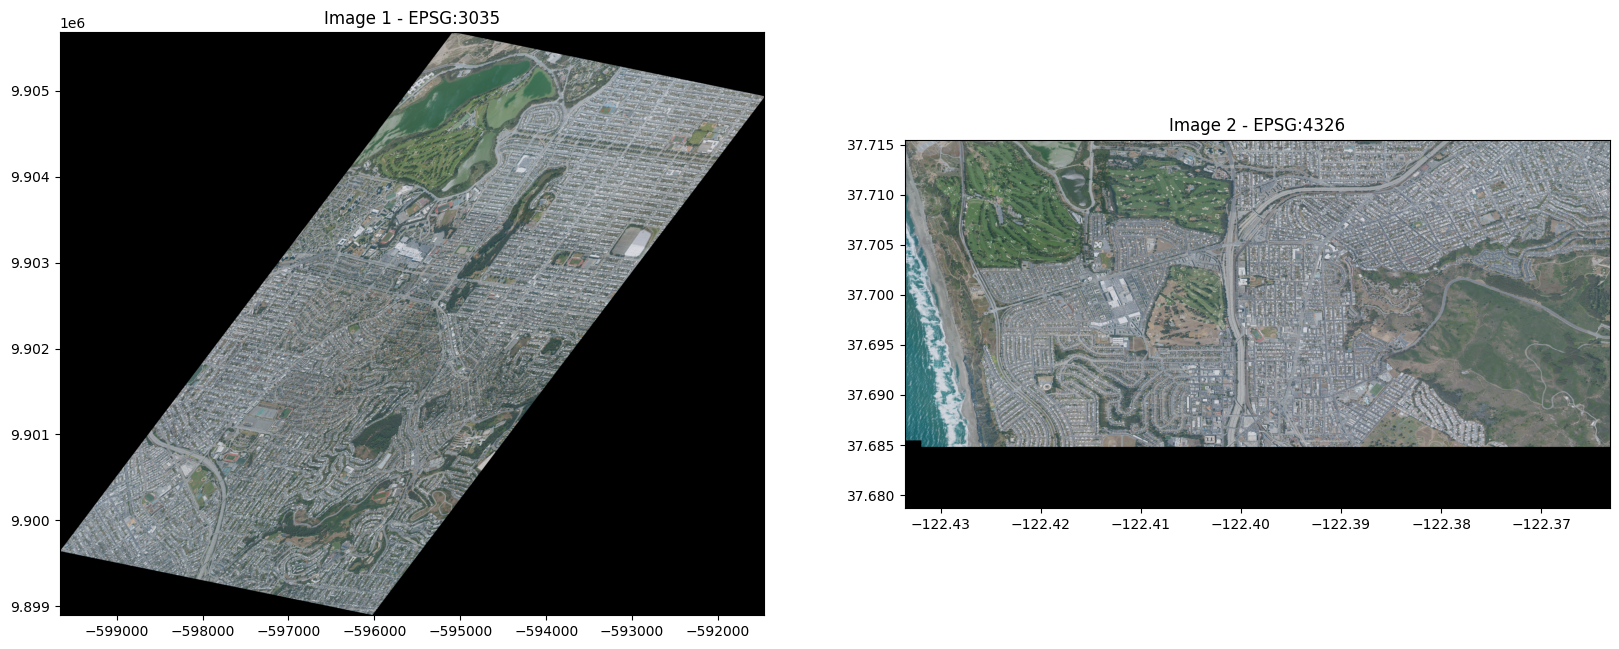

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Paths to the satellite images
image_path1 = '/content/drive/My Drive/ML4EO/Data/NAIP1.tif'
image_path2 = '/content/drive/My Drive/ML4EO/Data/NAIP2.tif'

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Reading and displaying the first image
with rasterio.open(image_path1) as src1:
    axs[0].set_title('Image 1 - EPSG:3035')
    show(src1, ax=axs[0])

# Reading and displaying the second image
with rasterio.open(image_path2) as src2:
    axs[1].set_title('Image 2 - EPSG:4326')
    show(src2, ax=axs[1])

plt.show()

In [ ]:
# pip install GDAL

# **3.3 Reprojecting NAIP2.tif to Match NAIP1.tif's Projection**

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define the source and target CRS
src_crs = 'EPSG:4326'  # Original CRS of NAIP2.tif
dst_crs = 'EPSG:3035'  # Target CRS to match NAIP1.tif

# Open the source image (NAIP2.tif)
with rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP2.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create and reproject to a new image (NAIP2_reprojected.tif)
    with rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP2_reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

# **Mosaicking the Reprojected Image with the Original NAIP1.tif**

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
import matplotlib.pyplot as plt

# Assuming other parts of your script are correct and just focusing on the correction:

# Open the reprojected NAIP2.tif and original NAIP1.tif
with rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP1.tif') as src1, \
     rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP2_reprojected.tif') as src2:
    # Merge them
    mosaic, out_trans = merge([src1, src2])
    out_meta = src1.meta.copy()

# Update the metadata for the mosaic
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "EPSG:3035"  # or whatever CRS you've reprojected to
                 })

# Save the mosaic to a new file
with rasterio.open('/content/drive/My Drive/ML4EO/Data/Mosaic.tif', 'w', **out_meta) as dest:
    dest.write(mosaic)

# Optionally, display the mosaic
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
show(mosaic, ax=ax)

<Axes: >

**Reprojecting NAIP1.tif to Match NAIP2.tif's Projection**

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define the source and target CRS
src_crs = 'EPSG:3035'  # Original CRS of NAIP1.tif
dst_crs = 'EPSG:4326'  # Target CRS to match NAIP2.tif

# Open the source image (NAIP1.tif)
with rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP1.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create and reproject to a new image (NAIP1_reprojected.tif)
    with rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP1_reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

**Mosaicking the Reprojected Image with the Target NAIP2.tif**

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
import matplotlib.pyplot as plt

# Open the original NAIP2.tif and the reprojected NAIP1.tif
with rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP2.tif') as src2, \
     rasterio.open('/content/drive/My Drive/ML4EO/Data/NAIP1_reprojected.tif') as src1_reprojected:
    # Merge them
    mosaic, out_trans = merge([src1_reprojected, src2])
    out_meta = src1_reprojected.meta.copy()

# Update the metadata for the mosaic
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": "EPSG:4326"  # Updated to the CRS of NAIP2.tif
})

# Save the mosaic to a new file
with rasterio.open('/content/drive/My Drive/ML4EO/Data/Mosaic_reprojected.tif', 'w', **out_meta) as dest:
    dest.write(mosaic)

# Optionally, display the mosaic
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
show(mosaic, ax=ax)
plt.show()  # Make sure to show the plot if you're running this in a script


# **4. Analysis of Before and After Projection Correction**

# **Before Projection Correction (B1.png)**
![alt text](https://drive.google.com/uc?export=view&id=1lbTO9FilGjUB-MBxS7uR45O-IL8MAKIL)

In the first mosaic (B1.png), which combines the images without correcting the differing projections:

**Perspective Distortion:** The overall perspective of the mosaic appears skewed. This distortion is due to the differing spatial reference frames — with the first image being in EPSG:3035, which distorts shapes to preserve area, and the second in EPSG:4326, which represents geographic coordinates without preserving area or shape.

**Misalignment:** There is an apparent misalignment of features. Roads, buildings, and natural features do not line up between the two images, which could lead to significant errors in spatial analysis, such as incorrect feature mapping or data misinterpretation.

**Scale Inconsistency:** The scale between the two images is inconsistent, which can be particularly problematic for any measurements or analyses that rely on accurate distances or area calculations.

**Unnatural Transition:** The transition between the two images is abrupt and unnatural, with a clear delineation where one projection ends and the other begins. This would be jarring in a visual sense and misleading in an analytical context.

# **After Projection Correction (B2.png)**
![alt text](https://drive.google.com/uc?export=view&id=1DiD5urK19hcbEkNgZg4HWcY830waxu0a)

The second mosaic (B2.png) represents the images after aligning them to the same projection:

**Uniform Perspective:** The perspective in this mosaic is more uniform. Aligning both images to the same projection resolves the perspective distortion, allowing for a more natural and accurate representation of the landscape.

**Feature Alignment:** Geographic features such as roads, coastlines, and building footprints should now align across the mosaic. This is essential for creating a reliable base map for further spatial analysis or for integration with other datasets.

**Consistent Scale:** With both images in the same projection, the scale is now consistent across the mosaic. This allows for accurate distance and area measurements, which are critical for a wide range of applications, from urban planning to environmental monitoring.

**Natural Transition:** The transition between the images should be seamless, with no visible indication of the boundary between the original images. This not only improves the aesthetic quality of the mosaic but also its utility as a continuous spatial dataset.

# **Reflection on Challenges and Improvements**
The challenges in mosaicking images with differing projections are clearly demonstrated in the first mosaic **(B1.png)**. The potential errors that can arise from such a mosaic include incorrect interpretation of spatial relationships, misrepresentation of feature sizes and shapes, and the inability to use the mosaic for accurate spatial analysis or decision-making.

Correcting the projections as shown in the second mosaic (B2.png) significantly improves the overall quality and accuracy of the composite image. It becomes a more reliable source for analysis, as all spatial relationships are correctly represented, and measurements can be trusted. This correction process is vital for ensuring that the final product is useful for any practical application that depends on geospatial data.